# RNN Track classifier

In this notebook we explore a model which classifies a sequence of hits as a real or spurious track candidate. The model will produce a prediction for every element of the sequence, allowing us to classify partial candidates and guide a combinatorial track building algorithm.

In [19]:
%%javascript
$('.nbp-app-bar').toggle()

<IPython.core.display.Javascript object>

In [2]:
from __future__ import print_function
import os

# Data/ML libraries
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Local imports
from estimator import Estimator
import torchutils
torchutils.set_cuda(False)
from torchutils import np_to_torch, torch_to_np, torch_zeros

%matplotlib notebook

## Load the data

In [3]:
data_dir = '/global/cscratch1/sd/sfarrell/heptrkx/track_clf_data_001'

In [4]:
train_features = np.load(os.path.join(data_dir, 'train_features.npy'))
train_labels = np.load(os.path.join(data_dir, 'train_labels.npy'))
valid_features = np.load(os.path.join(data_dir, 'valid_features.npy'))
valid_labels = np.load(os.path.join(data_dir, 'valid_labels.npy'))
test_features = np.load(os.path.join(data_dir, 'test_features.npy'))
test_labels = np.load(os.path.join(data_dir, 'test_labels.npy'))

In [5]:
print('Train features:', train_features.shape)
print('Train labels:', train_labels.shape)
print('Valid features:', valid_features.shape)
print('Valid labels:', valid_labels.shape)
print('Test features:', test_features.shape)
print('Test labels:', test_labels.shape)

Train features: (698961, 10, 3)
Train labels: (698961, 10)
Valid features: (87370, 10, 3)
Valid labels: (87370, 10)
Test features: (87371, 10, 3)
Test labels: (87371, 10)


## Define the model

We will use an RNN model to classify the sequences.

In [6]:
class HitSequenceClassifier(nn.Module):
    """
    A recurrent network model which classifies all elements of a hit sequence.
    """
    
    def __init__(self, n_features=3, hidden_dim=16):
        """Initialize the model"""
        super(HitSequenceClassifier, self).__init__()
        self.lstm = nn.LSTM(n_features, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # Initialize the lstm hidden state
        var_args = [x.size(0), self.lstm.hidden_size]
        h0 = torchutils.torch_zeros(*var_args), torchutils.torch_zeros(*var_args)
        h, _ = self.lstm(x, h0)
        h = self.linear(h).squeeze(-1)
        return F.sigmoid(h)

## Train the model

In [7]:
# Setup logging
import logging
reload(logging)
log_format = '%(asctime)s %(levelname)s %(message)s'
logging.basicConfig(level=logging.INFO, format=log_format)

In [8]:
# Model config
hidden_dim = 32

# Training config
n_epochs = 32
batch_size = 32
valid_frac = 0

In [9]:
# Finalize the training, validation, and test data
train_x = np_to_torch(train_features)
train_y = np_to_torch(train_labels)
valid_x = np_to_torch(valid_features)
valid_y = np_to_torch(valid_labels)
test_x = np_to_torch(test_features)
test_y = np_to_torch(test_labels)

In [10]:
# Construct the model, loss, and estimator
model = HitSequenceClassifier(hidden_dim=hidden_dim)
loss_func = nn.BCELoss()
estimator = Estimator(model, loss_func)

2018-02-12 21:37:47,436 INFO Model: 
HitSequenceClassifier(
  (lstm): LSTM(3, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=1)
)
2018-02-12 21:37:47,437 INFO Parameters: 4769


In [11]:
estimator.fit(train_x, train_y, n_epochs=n_epochs, batch_size=batch_size,
              valid_input=valid_x, valid_target=valid_y)

2018-02-12 21:37:47,444 INFO Training samples: 698961
2018-02-12 21:37:47,444 INFO Batches per epoch: 21843
2018-02-12 21:37:47,445 INFO Validation samples: 87370
2018-02-12 21:37:47,446 INFO Epoch 0
2018-02-12 21:39:34,539 INFO   training loss 0.0447 time 107.093s
2018-02-12 21:39:40,042 INFO   validate loss 0.0242
2018-02-12 21:39:40,043 INFO Epoch 1
2018-02-12 21:41:28,221 INFO   training loss 0.0138 time 108.177s
2018-02-12 21:41:33,532 INFO   validate loss 0.0101
2018-02-12 21:41:33,533 INFO Epoch 2
2018-02-12 21:43:24,892 INFO   training loss 0.0089 time 111.358s
2018-02-12 21:43:30,890 INFO   validate loss 0.00728
2018-02-12 21:43:30,891 INFO Epoch 3
2018-02-12 21:45:24,371 INFO   training loss 0.00687 time 113.479s
2018-02-12 21:45:30,403 INFO   validate loss 0.00624
2018-02-12 21:45:30,404 INFO Epoch 4
2018-02-12 21:47:18,492 INFO   training loss 0.00575 time 108.087s
2018-02-12 21:47:23,703 INFO   validate loss 0.00569
2018-02-12 21:47:23,704 INFO Epoch 5
2018-02-12 21:49:17,

In [36]:
# Continue training
n_epochs_continue = 16
estimator.fit(train_x, train_y, n_epochs=n_epochs_continue, batch_size=batch_size,
              valid_input=valid_x, valid_target=valid_y)

2018-02-13 09:04:18,079 INFO Training samples: 698961
2018-02-13 09:04:18,080 INFO Batches per epoch: 21843
2018-02-13 09:04:18,081 INFO Validation samples: 87370
2018-02-13 09:04:18,082 INFO Epoch 32
2018-02-13 09:06:38,342 INFO   training loss 0.0018 time 140.26s
2018-02-13 09:06:44,544 INFO   validate loss 0.0018
2018-02-13 09:06:44,545 INFO Epoch 33
2018-02-13 09:09:03,806 INFO   training loss 0.00175 time 139.26s
2018-02-13 09:09:09,708 INFO   validate loss 0.00173
2018-02-13 09:09:09,709 INFO Epoch 34
2018-02-13 09:11:29,181 INFO   training loss 0.00173 time 139.471s
2018-02-13 09:11:34,484 INFO   validate loss 0.00173
2018-02-13 09:11:34,485 INFO Epoch 35
2018-02-13 09:13:53,835 INFO   training loss 0.00169 time 139.349s
2018-02-13 09:13:59,550 INFO   validate loss 0.00166
2018-02-13 09:13:59,551 INFO Epoch 36
2018-02-13 09:16:20,862 INFO   training loss 0.00169 time 141.311s
2018-02-13 09:16:26,302 INFO   validate loss 0.00163
2018-02-13 09:16:26,303 INFO Epoch 37
2018-02-13 09

<IPython.core.display.Javascript object>


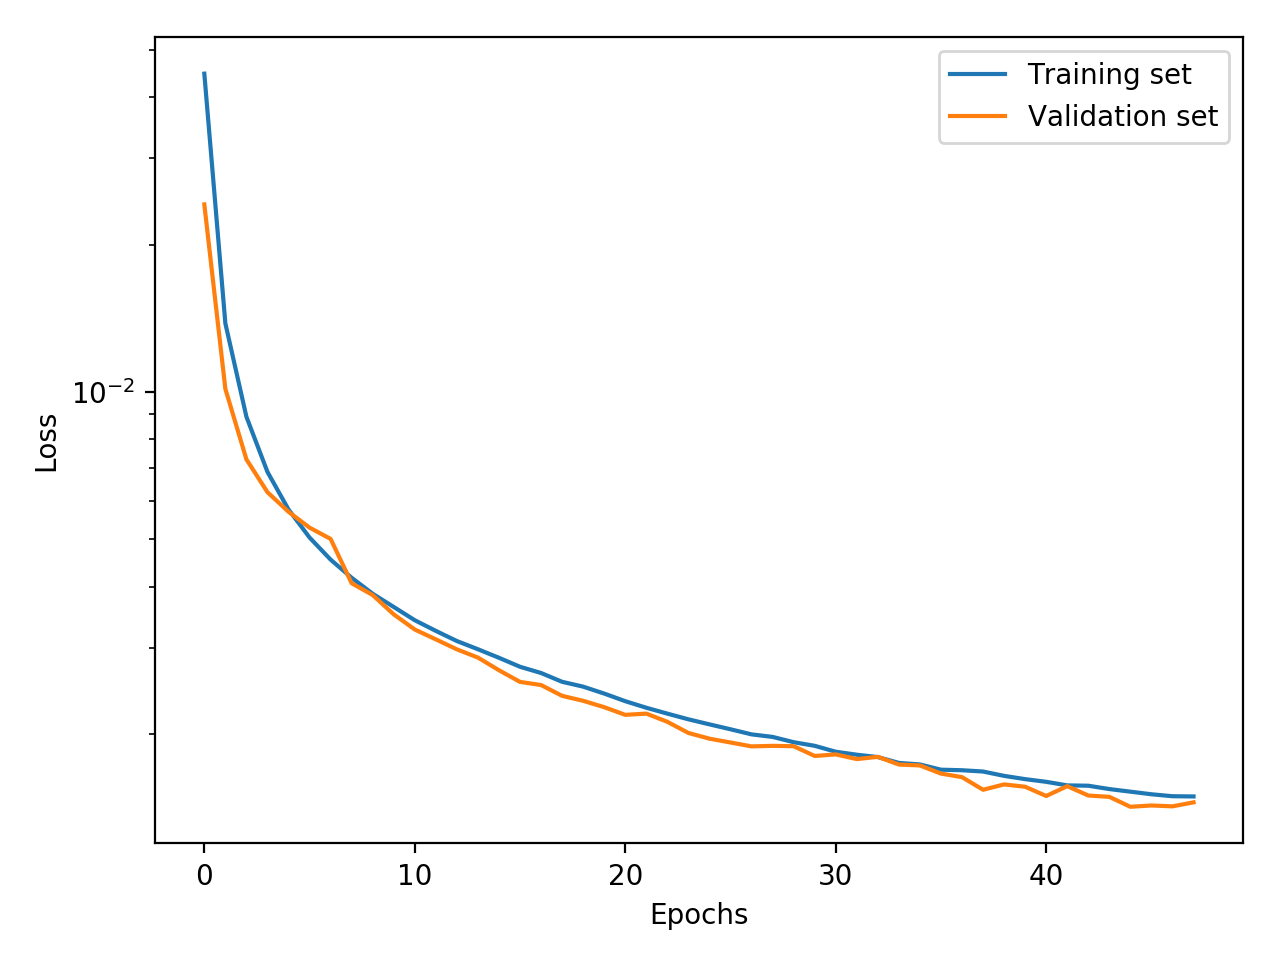

In [37]:
# Plot the training loss
plt.figure()
plt.semilogy(estimator.train_losses, label='Training set')
plt.semilogy(estimator.valid_losses, label='Validation set')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc=0)
plt.tight_layout()

## Evaluate the model

In [38]:
test_output = estimator.model(test_x)
test_pred = torch_to_np(test_output)

In [39]:
# Take a fixed decision threshold and compute the accuracy
threshold = 0.5
test_matches = (test_pred > threshold) == (test_labels > threshold)
test_accuracy = test_matches.mean()
print('Test set accuracy:', test_accuracy)

Test set accuracy: 0.999660070275


### ROC curve

In [40]:
fpr, tpr, cuts = roc_curve(test_labels.flatten(), test_pred.flatten())

<IPython.core.display.Javascript object>


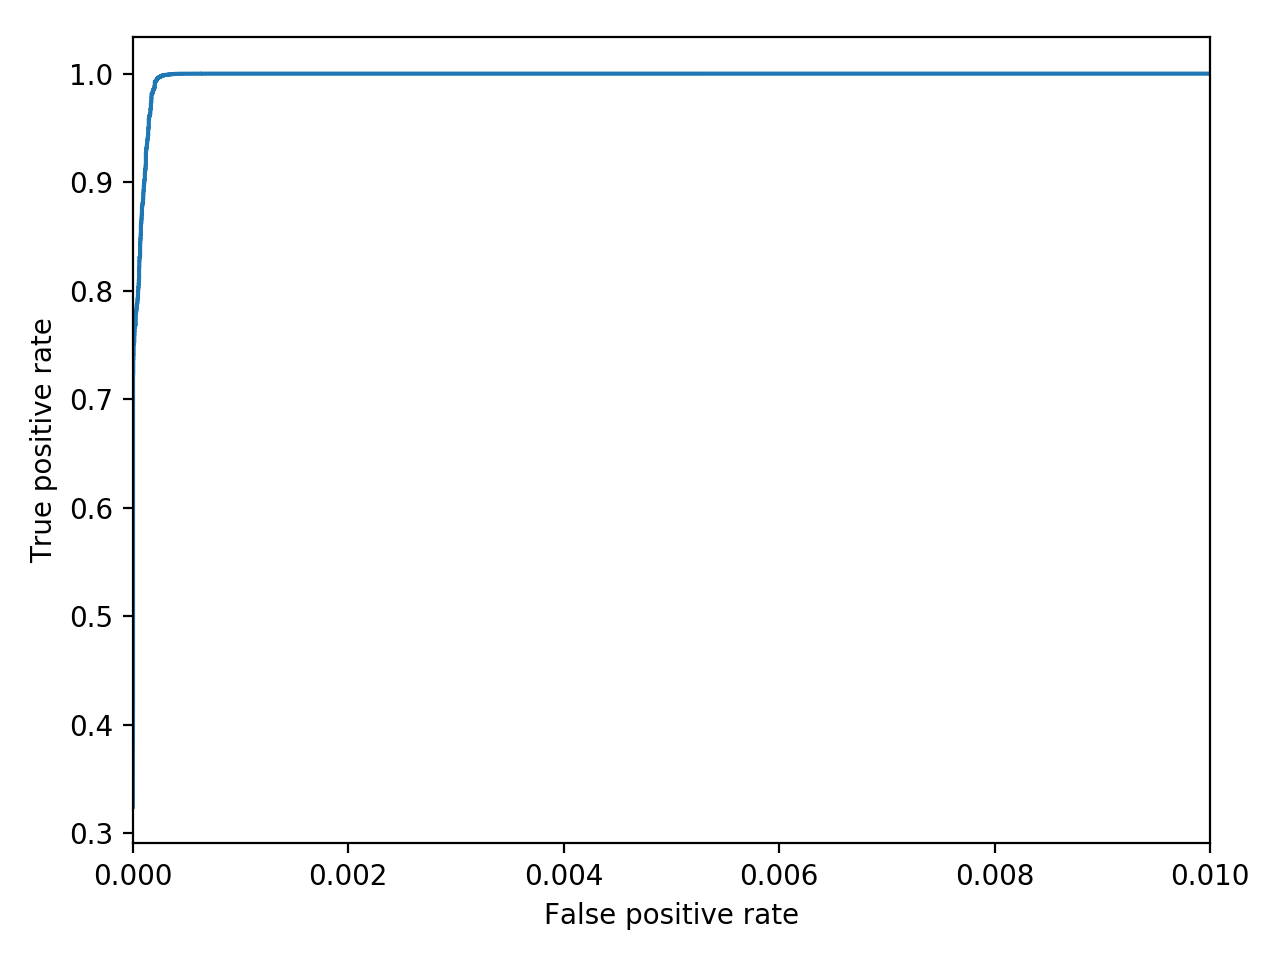

In [41]:
plt.figure()
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xlim(0, 0.01)
plt.tight_layout()

### Visualize classified tracks

Let's take a look at the most wrongly classified tracks.

In [17]:
sorted_tracks = test_matches.sum(axis=1).argsort()

#### Draw some of the best scored tracks

<IPython.core.display.Javascript object>


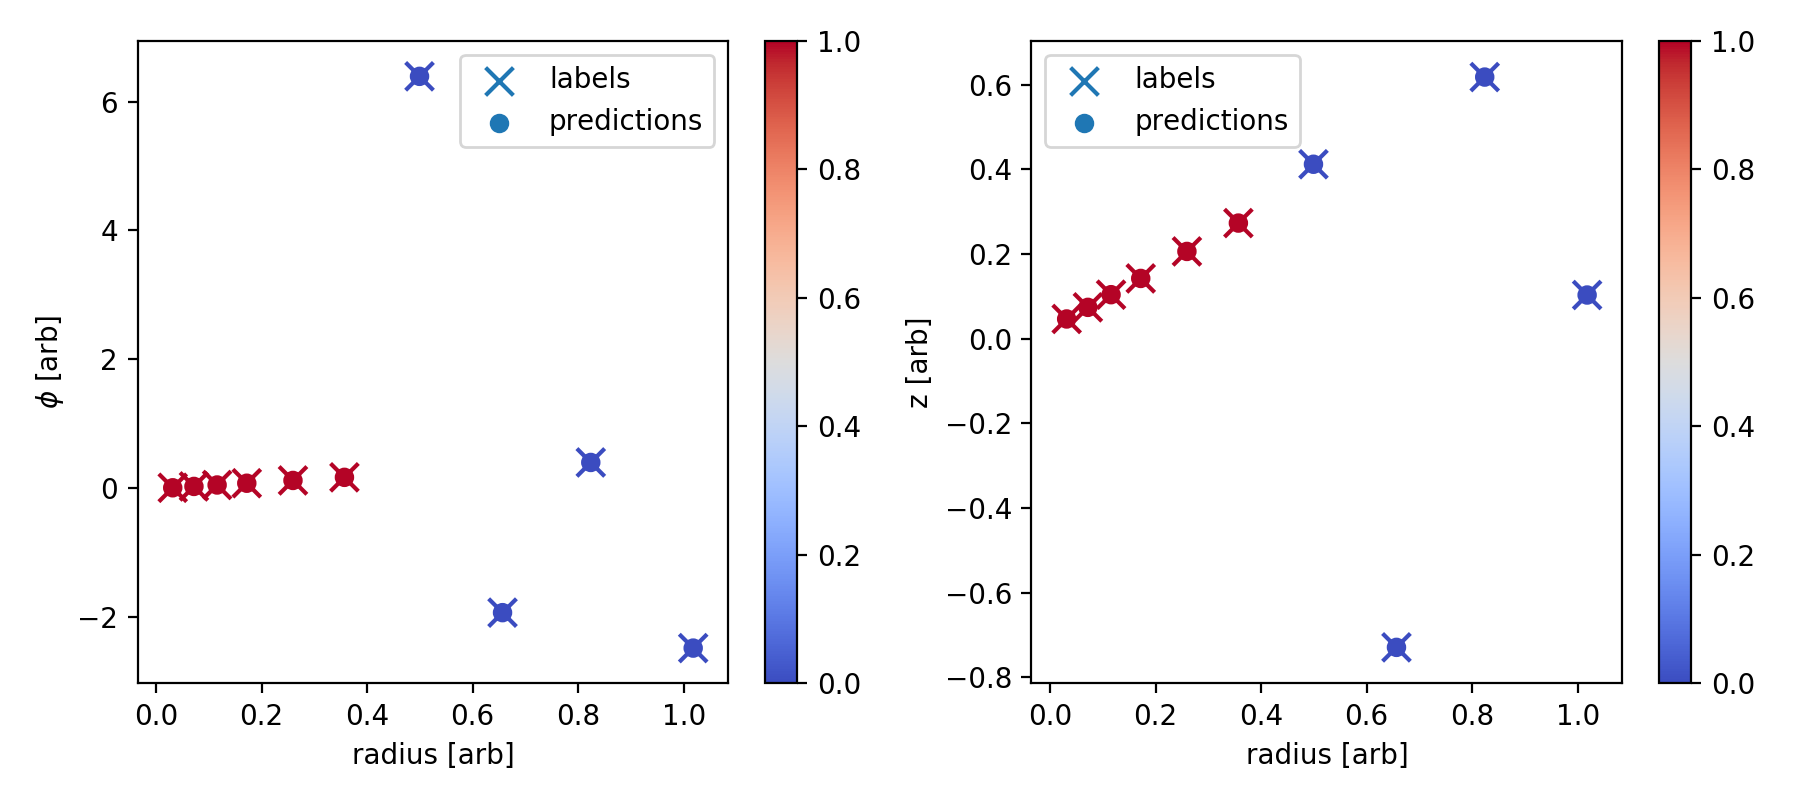

<IPython.core.display.Javascript object>


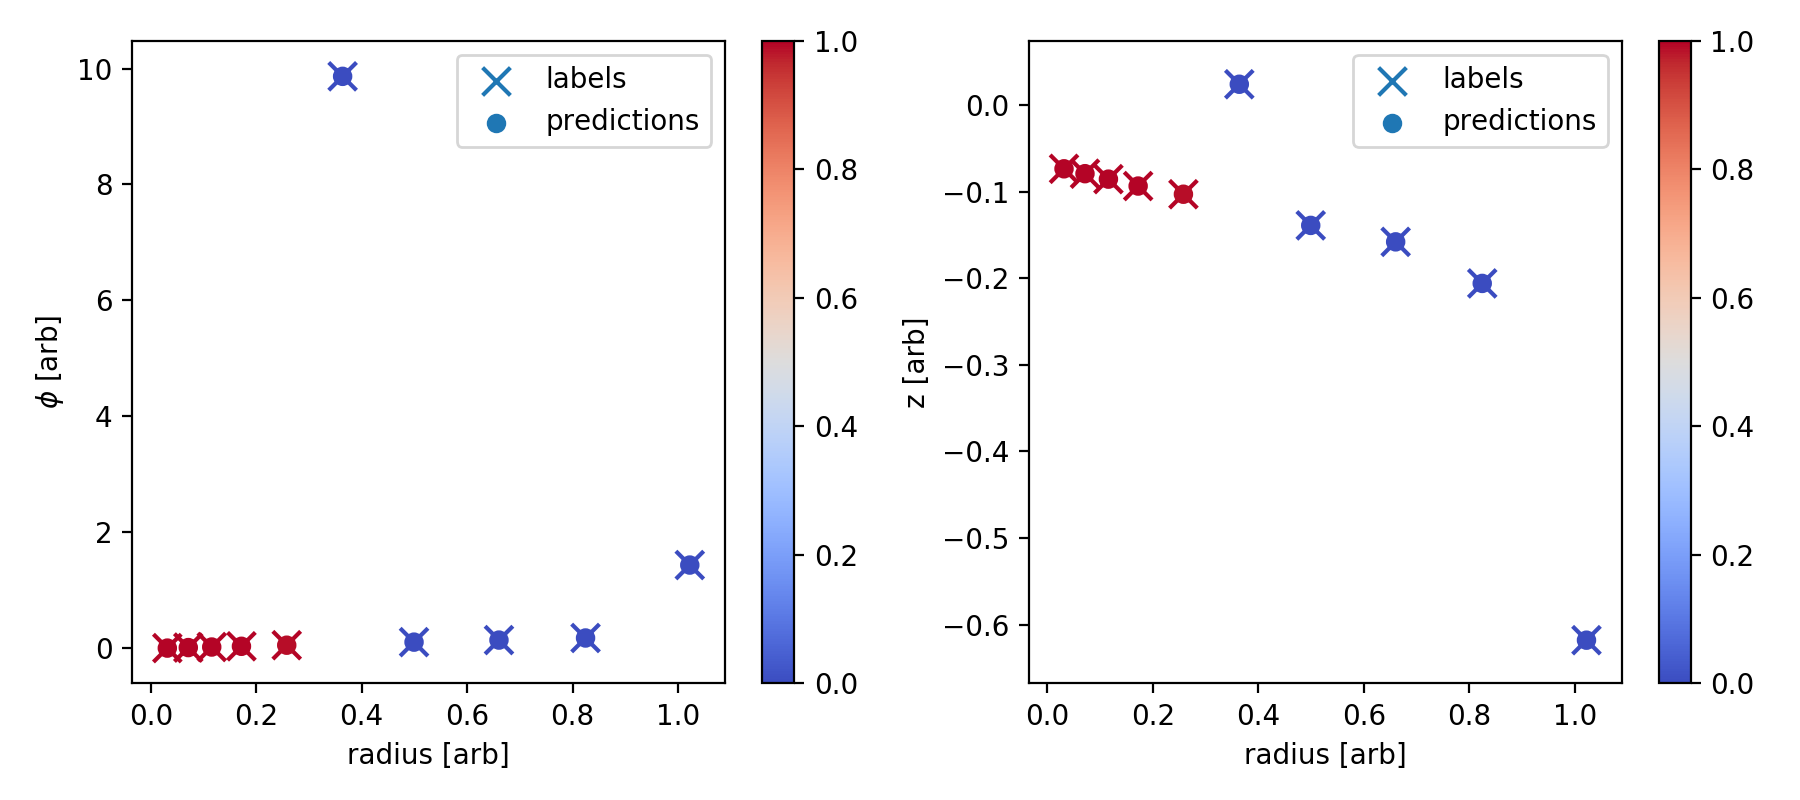

<IPython.core.display.Javascript object>


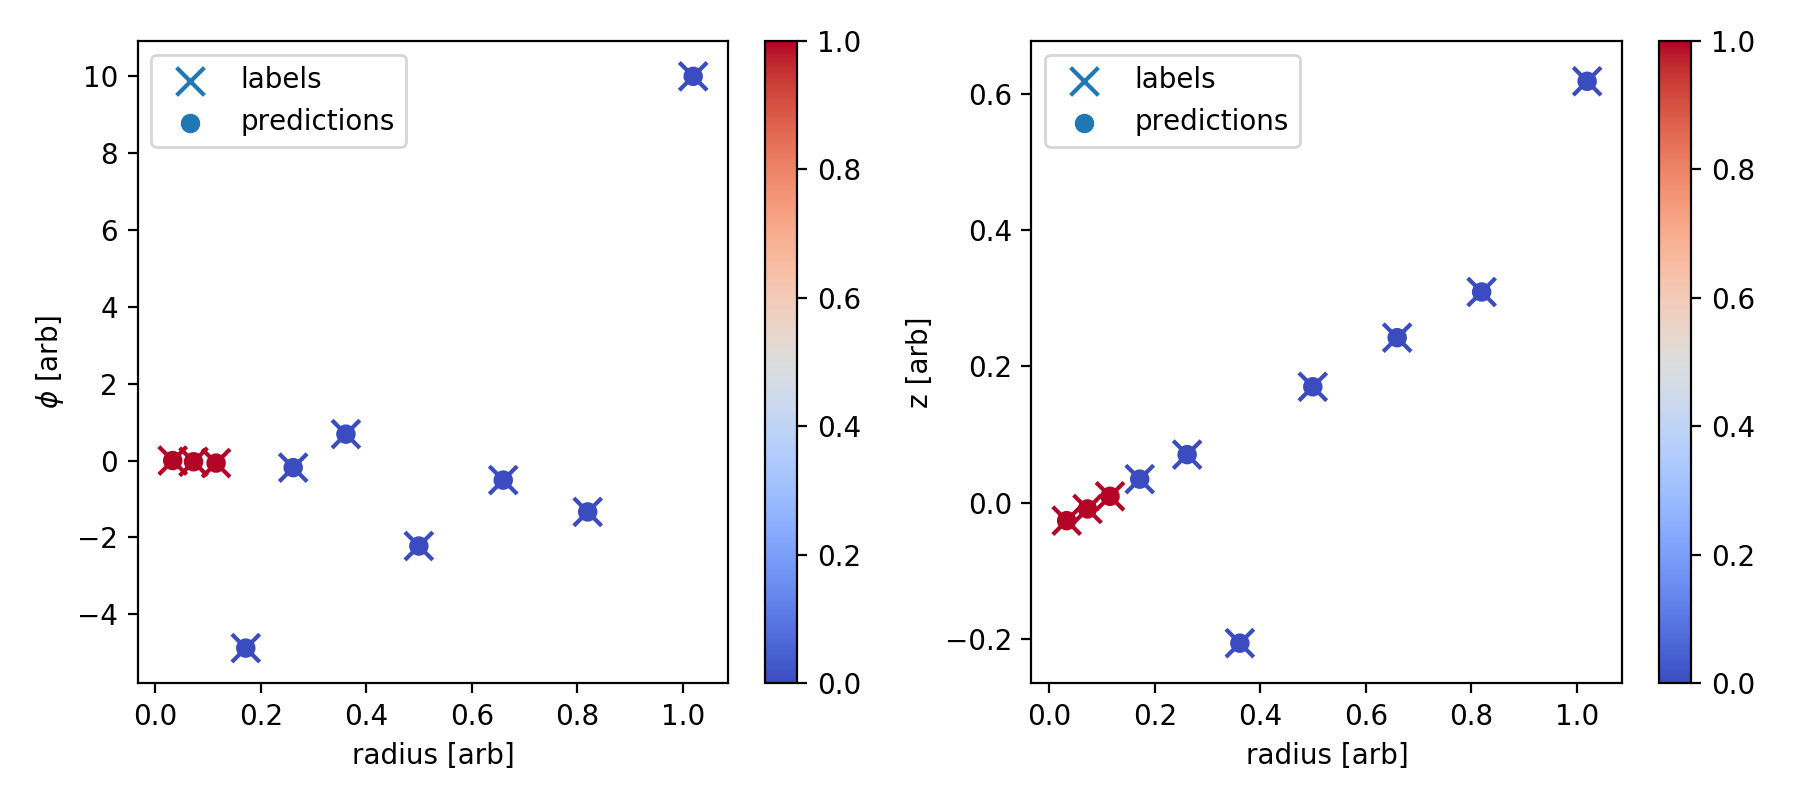

<IPython.core.display.Javascript object>


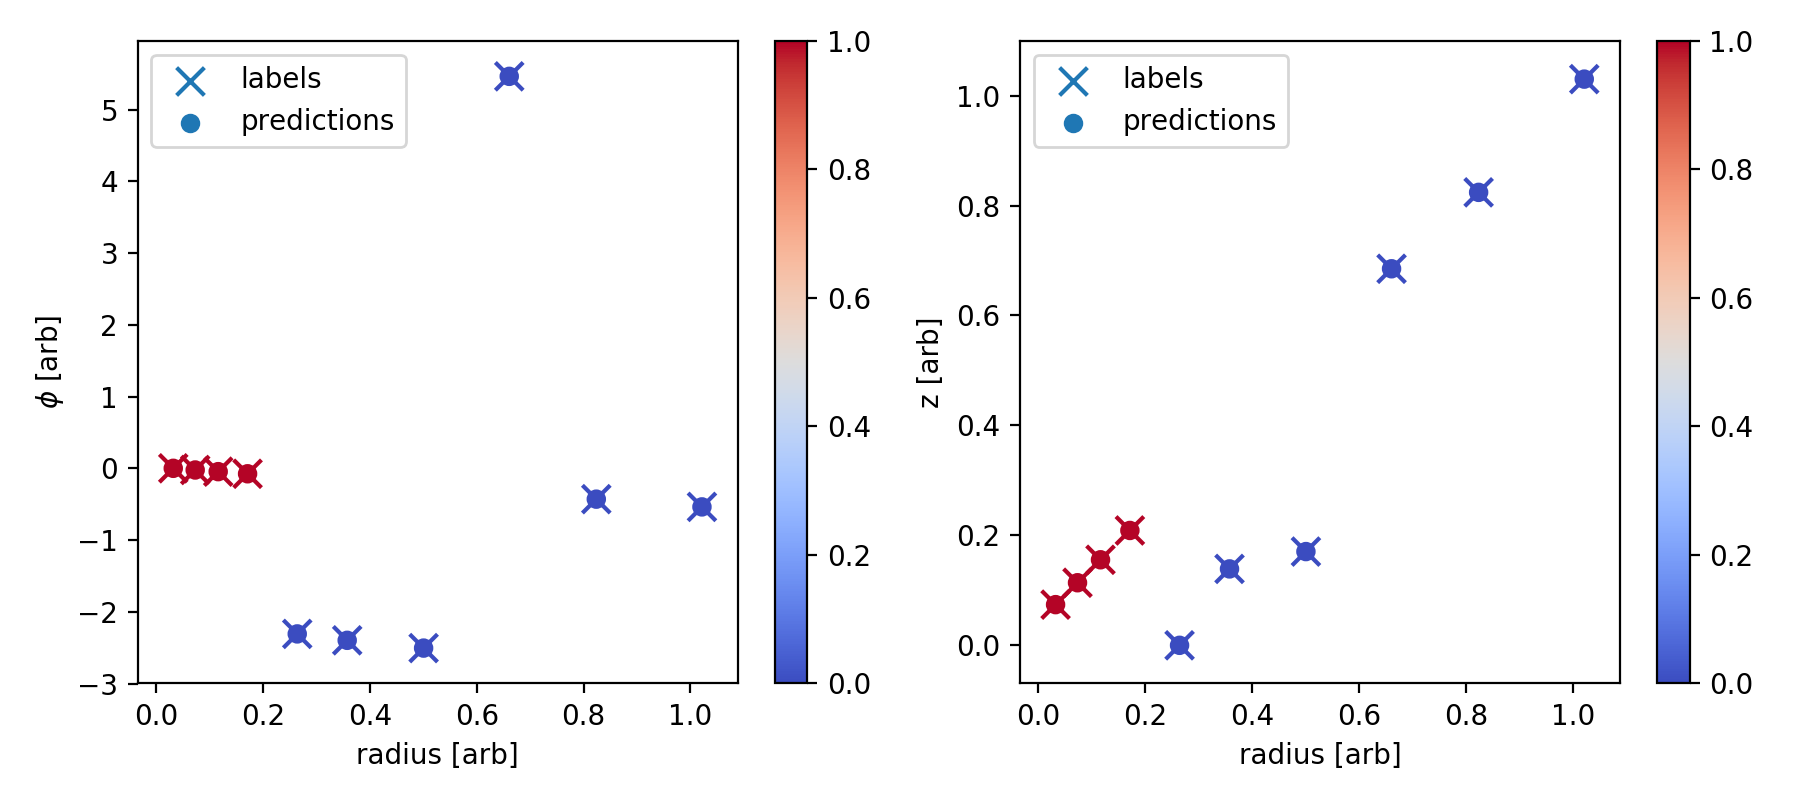

<IPython.core.display.Javascript object>


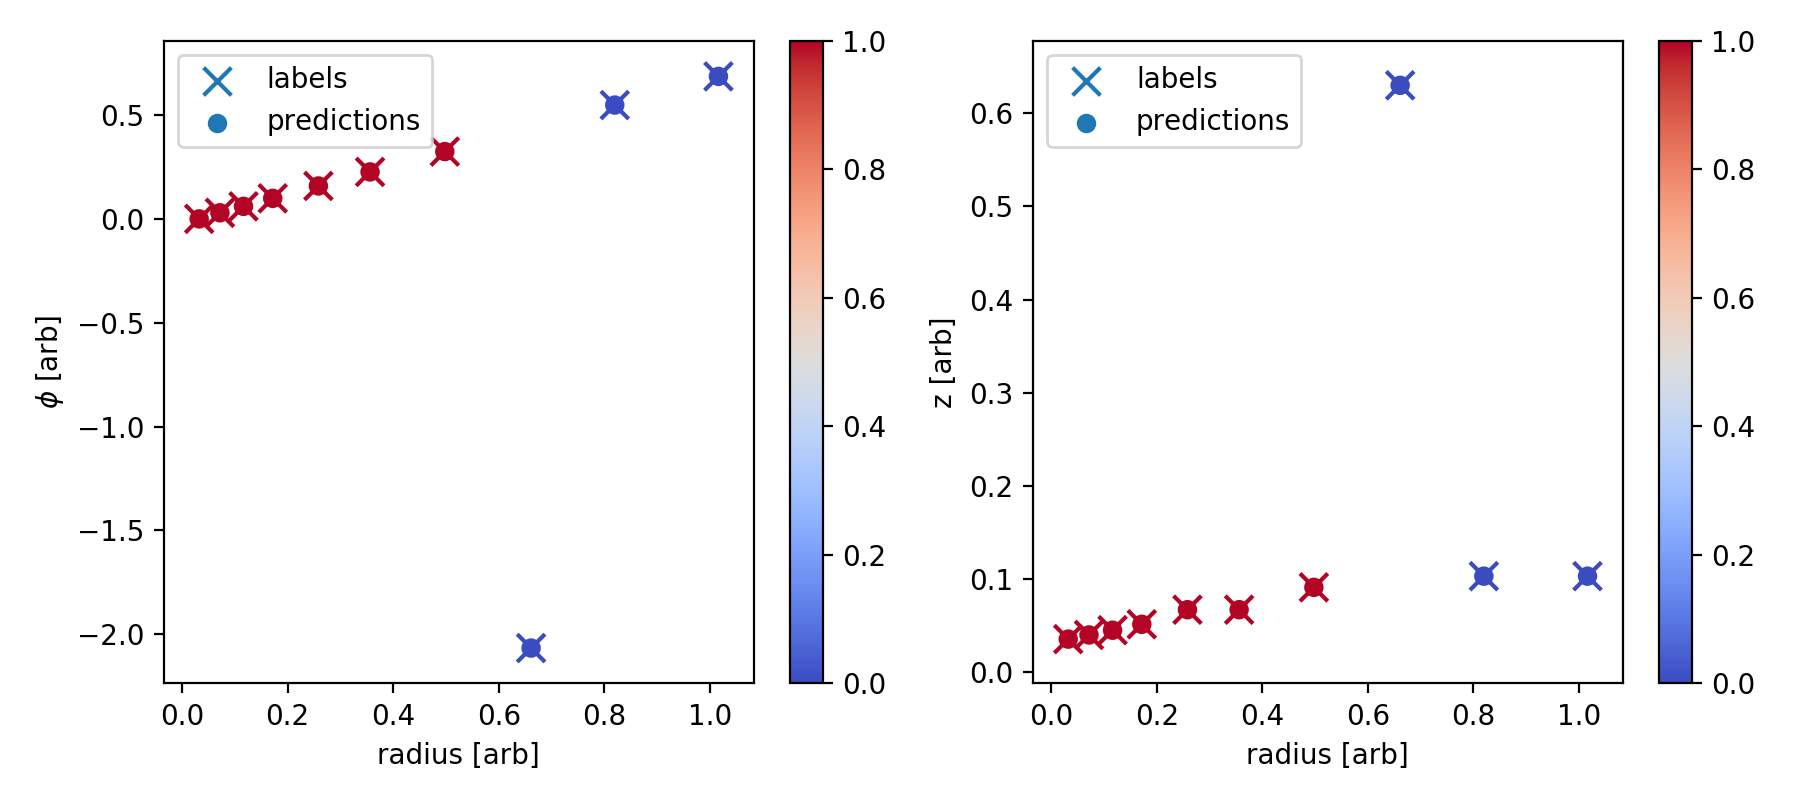

In [35]:
n_draw = 5
for i in sorted_tracks[-n_draw:]:

    plt.figure(figsize=(9,4))

    # Sample features
    sample_phi = test_features[i,:,0]
    sample_z = test_features[i,:,1]
    sample_r = test_features[i,:,2]

    # Draw options
    label_args = dict(label='labels', c=test_labels[i], cmap='coolwarm',
                      vmin=0, vmax=1, marker='x', s=100)
    pred_args = dict(label='predictions', c=test_pred[i], cmap='coolwarm',
                     vmin=0, vmax=1)

    # Draw r-phi hits with predictions and labels
    plt.subplot(121)
    plt.scatter(sample_r, sample_phi, **label_args)
    plt.scatter(sample_r, sample_phi, **pred_args)
    plt.legend(loc=0)
    plt.colorbar()
    plt.xlabel('radius [arb]')
    plt.ylabel('$\phi$ [arb]')
    
    # Draw r-z hits with predictions and labels
    plt.subplot(122)
    plt.scatter(sample_r, sample_z, **label_args)
    plt.scatter(sample_r, sample_z, **pred_args)
    plt.legend(loc=0)
    plt.colorbar()
    plt.xlabel('radius [arb]')
    plt.ylabel('z [arb]')

    plt.tight_layout()

#### Draw some of the worst scored tracks

<IPython.core.display.Javascript object>


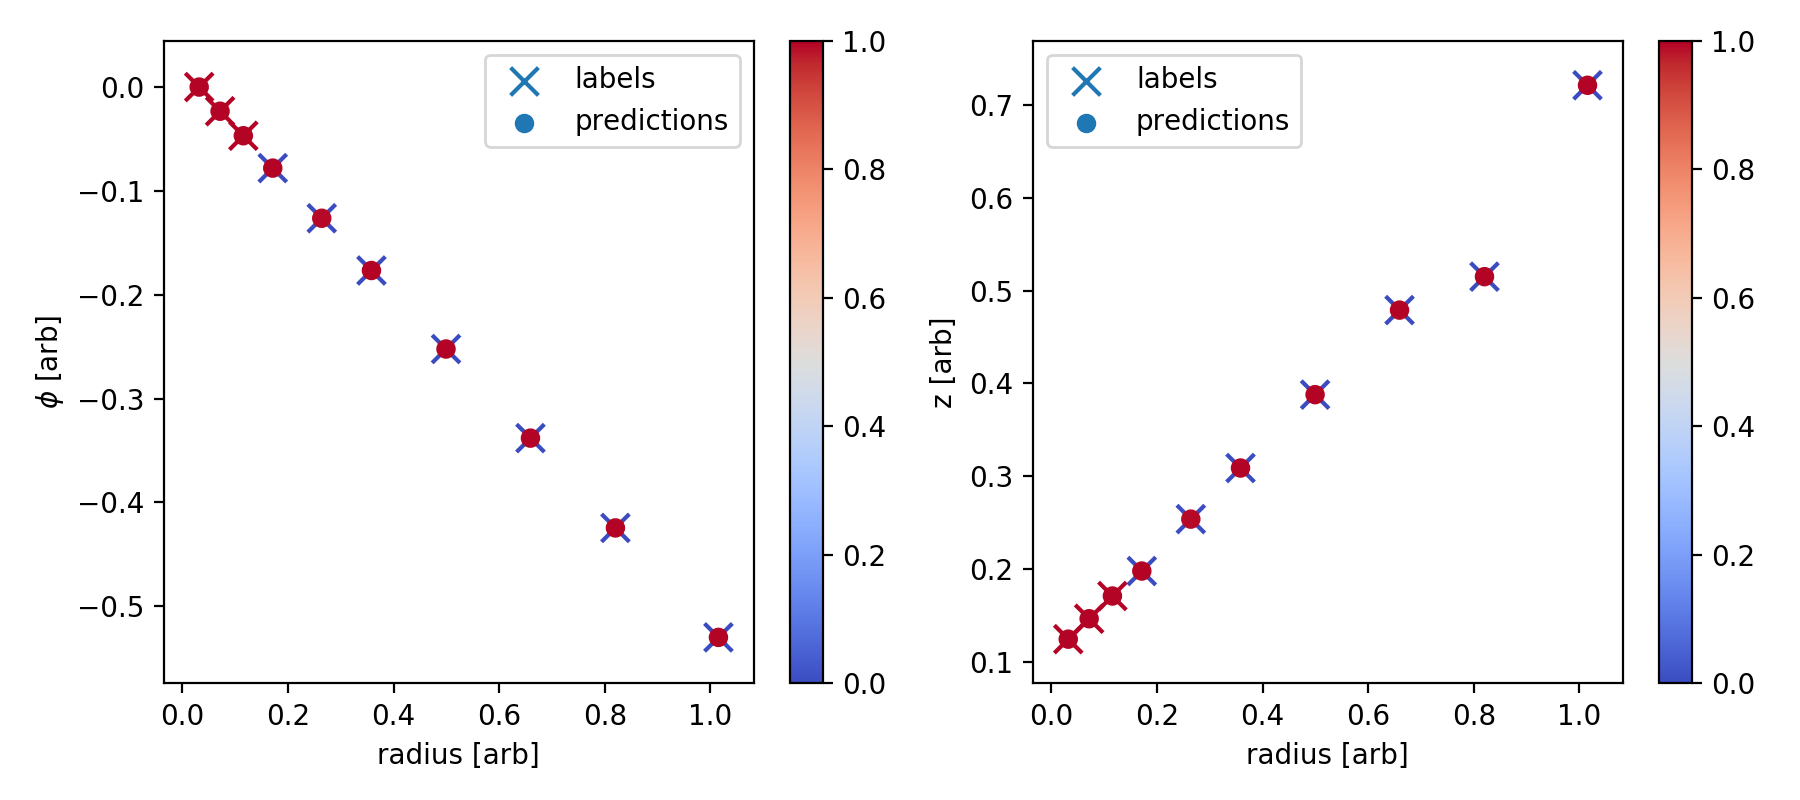

<IPython.core.display.Javascript object>


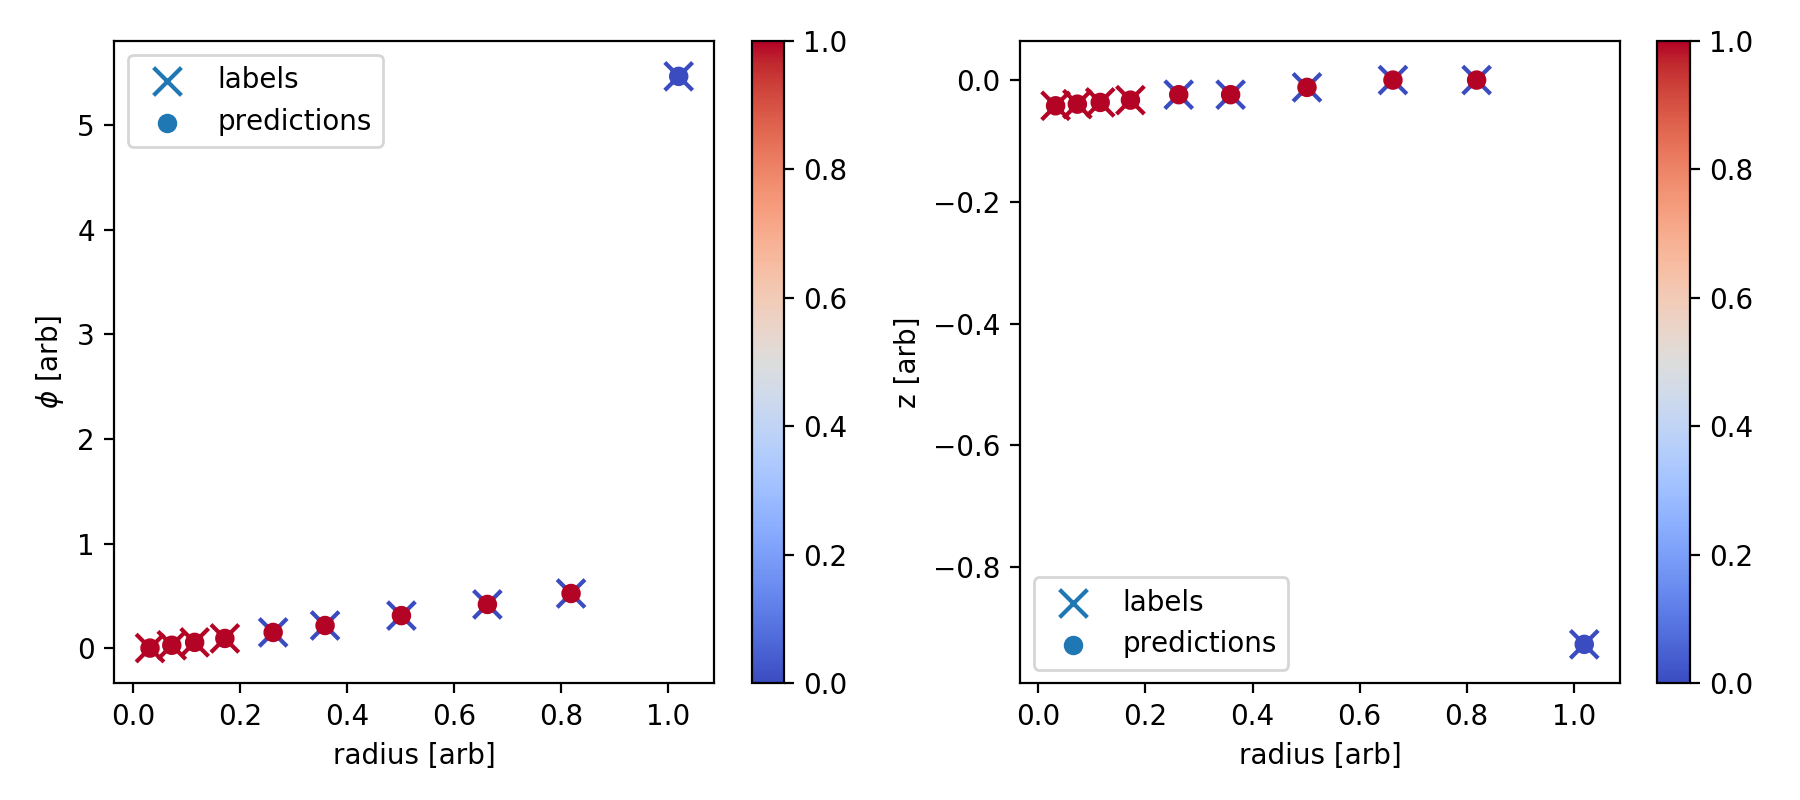

<IPython.core.display.Javascript object>


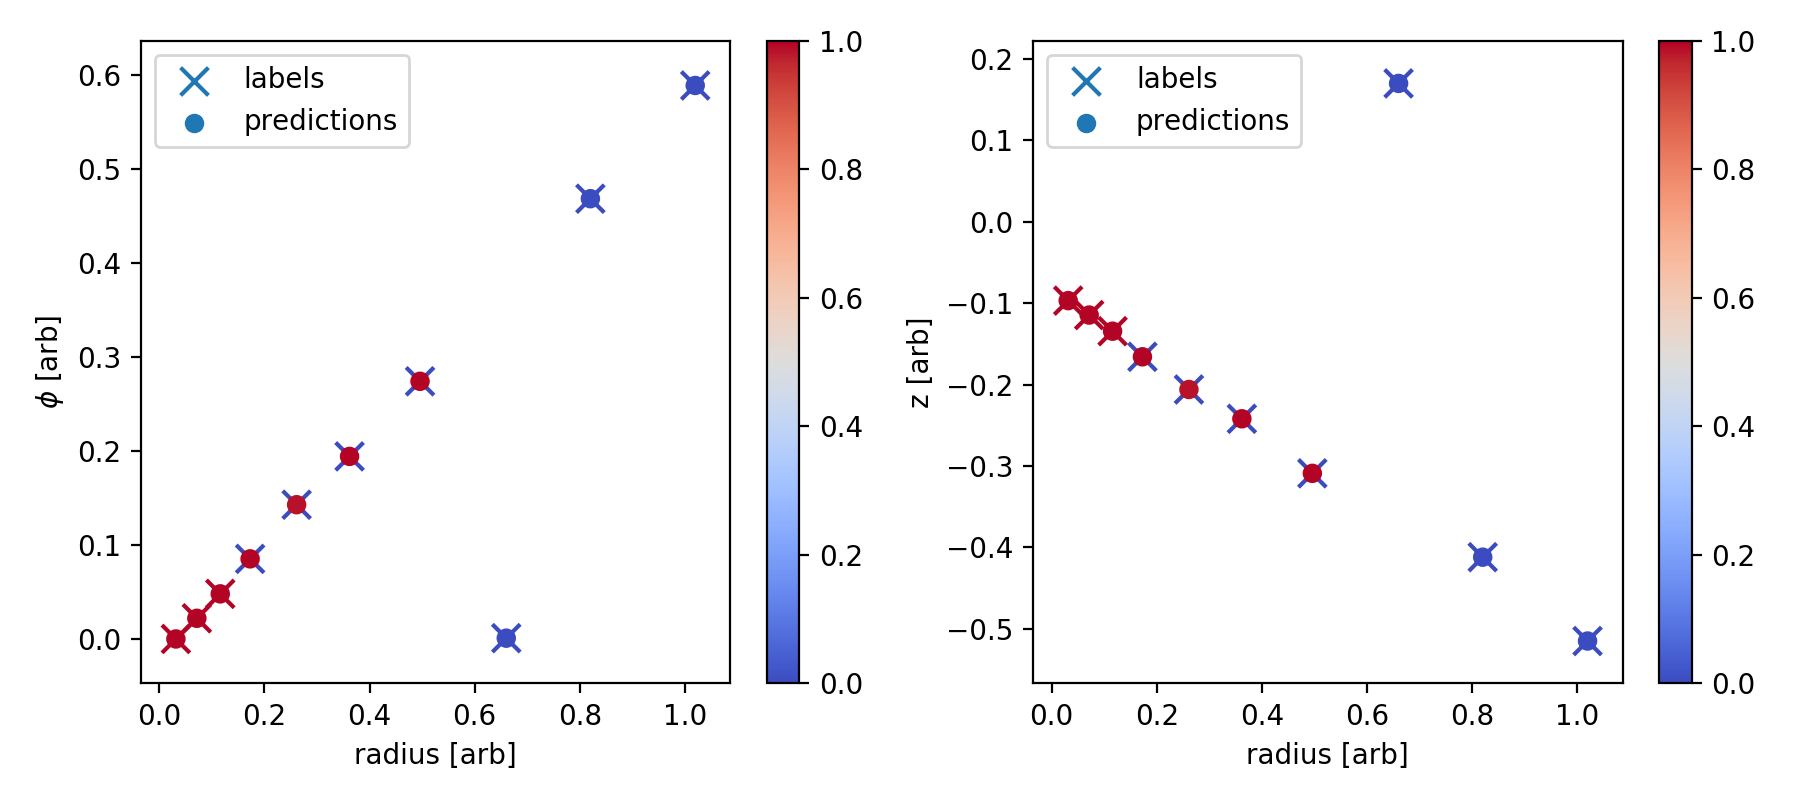

<IPython.core.display.Javascript object>


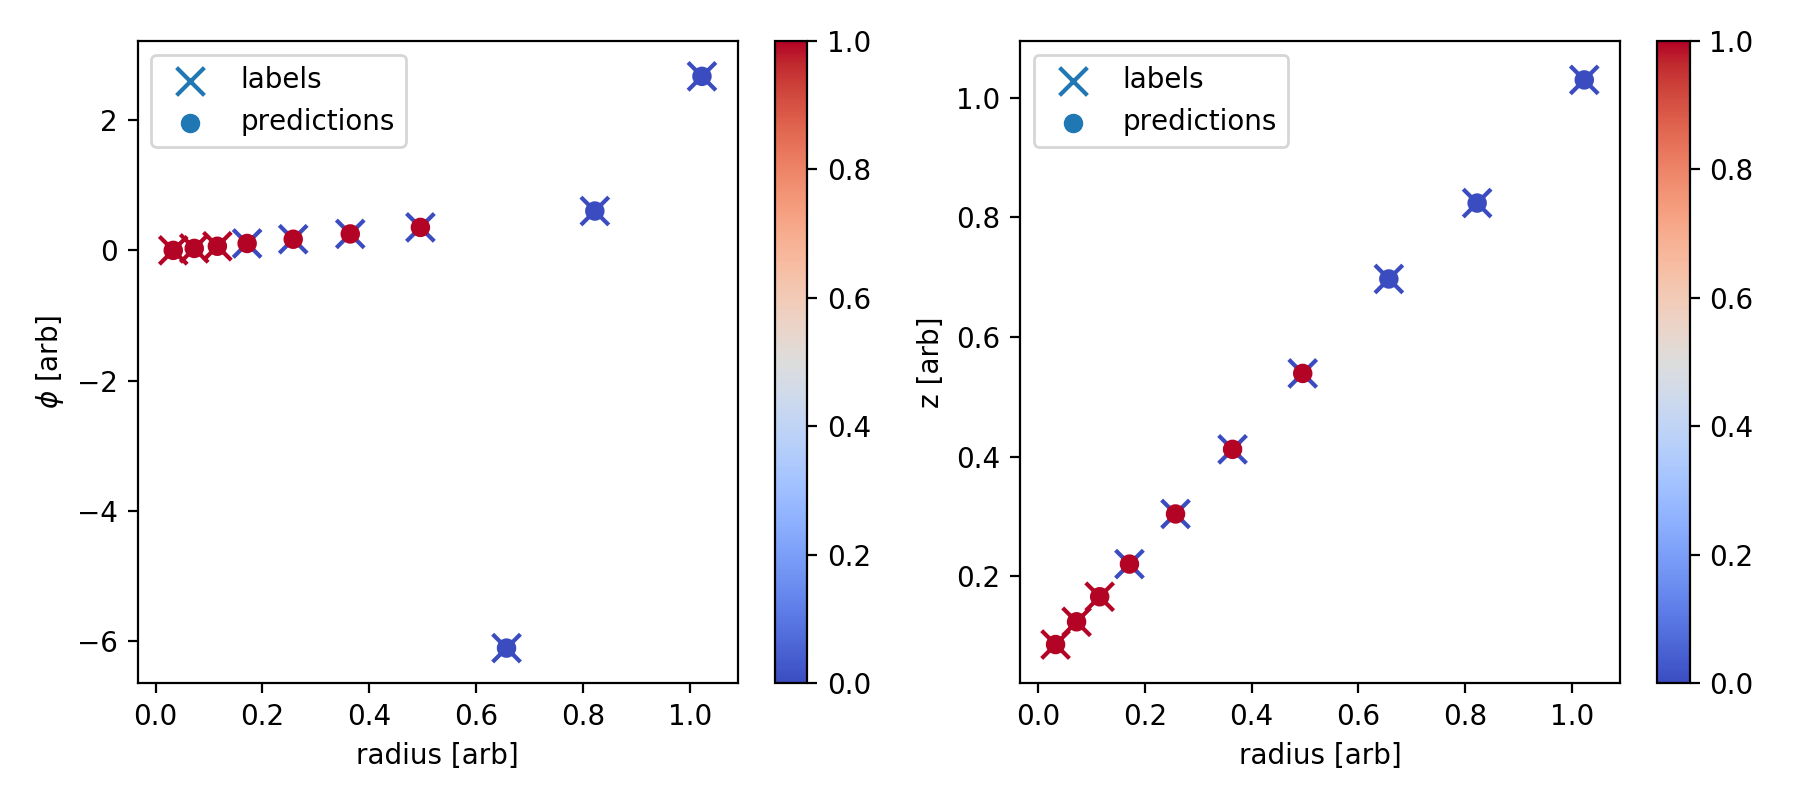

<IPython.core.display.Javascript object>


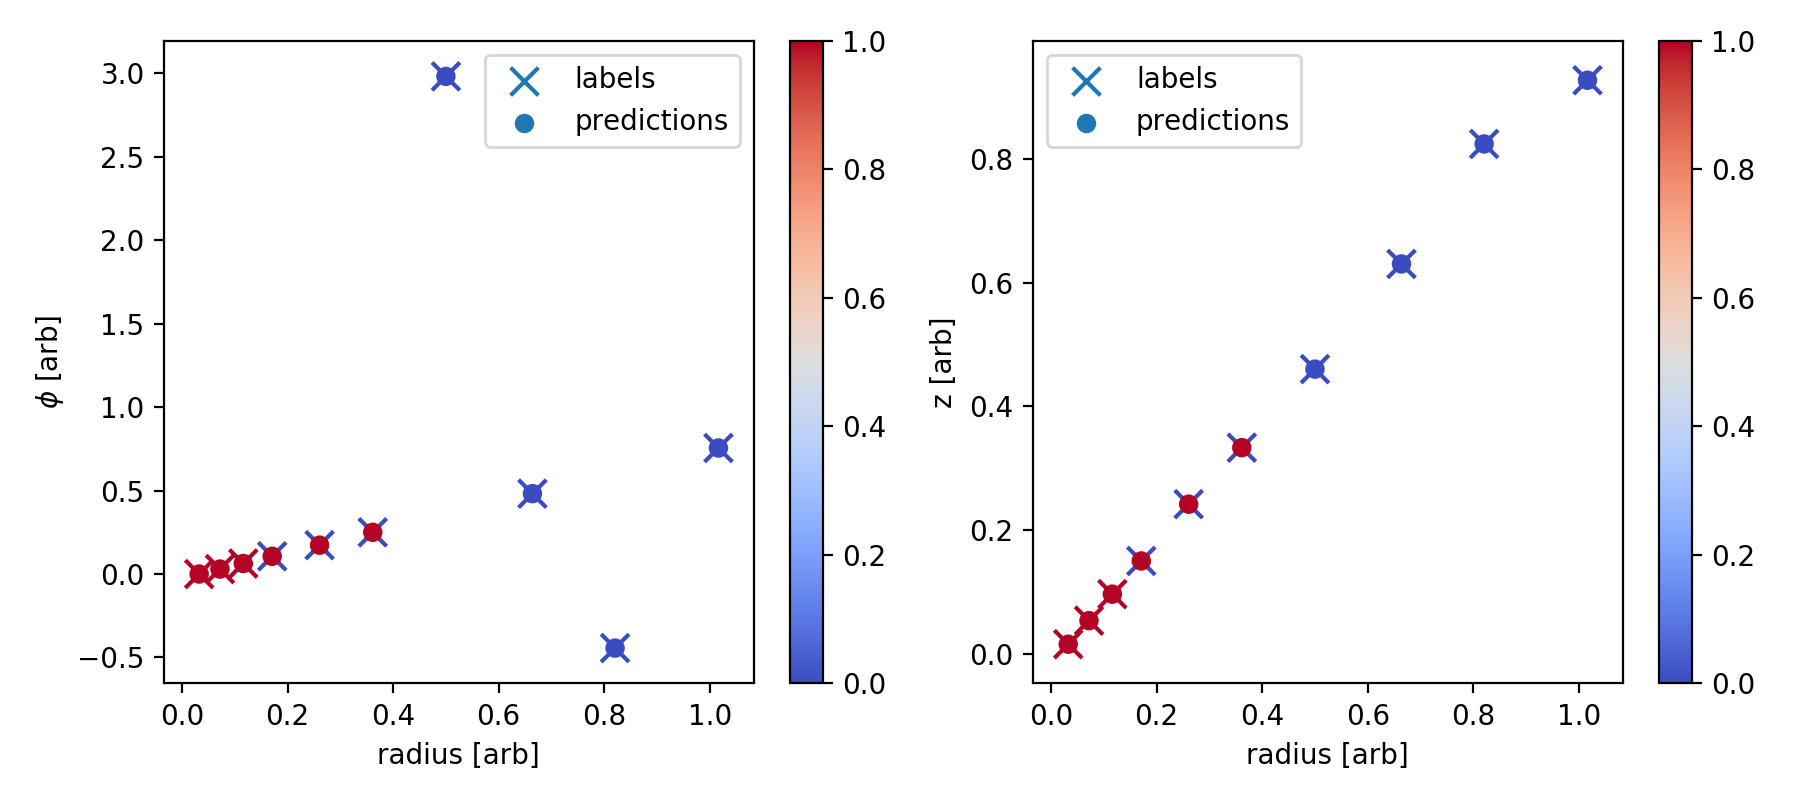

In [18]:
n_draw = 5
for i in sorted_tracks[:n_draw]:

    plt.figure(figsize=(9,4))

    # Sample features
    sample_phi = test_features[i,:,0]
    sample_z = test_features[i,:,1]
    sample_r = test_features[i,:,2]

    # Draw options
    label_args = dict(label='labels', c=test_labels[i], cmap='coolwarm',
                      vmin=0, vmax=1, marker='x', s=100)
    pred_args = dict(label='predictions', c=test_pred[i], cmap='coolwarm',
                     vmin=0, vmax=1)

    # Draw r-phi hits with predictions and labels
    plt.subplot(121)
    plt.scatter(sample_r, sample_phi, **label_args)
    plt.scatter(sample_r, sample_phi, **pred_args)
    plt.legend(loc=0)
    plt.colorbar()
    plt.xlabel('radius [arb]')
    plt.ylabel('$\phi$ [arb]')
    
    # Draw r-z hits with predictions and labels
    plt.subplot(122)
    plt.scatter(sample_r, sample_z, **label_args)
    plt.scatter(sample_r, sample_z, **pred_args)
    plt.legend(loc=0)
    plt.colorbar()
    plt.xlabel('radius [arb]')
    plt.ylabel('z [arb]')

    plt.tight_layout()